 RNN 的一大优势就在于捕捉网络之间的长期依赖性，网络之间的记忆性使得我们能够能用其来处理序列建模问题，但梯度消失使得 RNN 各层网络之间的依赖性变弱，RNN 的优势就难以发挥出来。针对这种问题，笔者继续向大家介绍两种变体的 RNN 结构，它们能够很好的处理梯度消失的情况，使得网络之间的记忆性得到保证。这两种 RNN 结构就是门控循环单元 GRU 和长短期记忆单元 LSTM。

经典的 RNN 结构如下图所示：
![在这里插入图片描述](https://img-blog.csdnimg.cn/20200617123049661.png)

 完整版的 GRU (门控循环单元GRU)示意图如下：
 ![在这里插入图片描述](https://img-blog.csdnimg.cn/20200617122527743.png)
 $当门值z_t结果为 1 的时候，(1-z_t)=0 ，细胞记忆值用 h_t 候选值进行更新，\\ 当门值z_t结果为 0 的时候，
 公式的后半部分为 0 ，细胞记忆值仍延用上一个时间步的值h_{t-1}，表示不更新记忆值。$

在 GRU 中我们通过更新门来决定是否要用记忆细胞候选值 ct_hat 来更新 ct。那么 LSTM 相较于 GRU 的变化在哪呢？LSTM 相较于 GRU 最大的特点就是更加复杂了，复杂到一个 LSTM 单元中有三个门控，但是复杂的结果就是相比于 GRU 有着更好的记忆性能。\
LSTM结构:
![请添加图片描述](https://img-blog.csdnimg.cn/20200617115836753.png)
![请添加图片描述](https://img-blog.csdnimg.cn/20200617115836749.png)
$接受来自输入 x^t 和上一层隐状态 a^{t-1} 的值进行加权计算处理。$
> **遗忘门(forget gate)**: 决定从记忆细胞中是否丢弃某些信息，这个过程就是遗忘门要干的事，我们通过一个 sigmoid 函数来进行处理。\
> **更新门（update gate）**:我们需要确定什么样的信息能存入细胞状态中。这跟我们在 GRU 中类似，除了计算更新门之外，还需要通过 tanh 计算记忆细胞的候选值 ct_hat。\
> **LSTM 结合遗忘门、更新门、上一层记忆细胞值和记忆细胞候选值来共同决定和更新当前细胞状态**：
![在这里插入图片描述](https://img-blog.csdnimg.cn/20200617121711982.png)
> **输出门（output gate）**:LSTM 提供了单独的输出门
![在这里插入图片描述](https://img-blog.csdnimg.cn/20200617121803254.png)

### numpy实现LSTM

In [124]:
import numpy as np 
def sigmoid(x):
    return 1/(1+np.exp(-x))
def softmax(x):
    x-=np.max(x)
    x=np.exp(x)
    return x/np.sum(x,axis=0)

#### 一个 LSTM 单元

In [125]:

def lstm_cell_forward(c_prev,a_prev,xt,params):
    '''
    m,n=xt.shape 
    m：特征值、n：样本数
    '''
    w_f,b_f=params['w_f'],params['b_f']
    w_u,b_u=params['w_u'],params['b_u']
    w_c,b_c=params['w_c'],params['b_c']
    w_o,b_o=params['w_o'],params['b_o']
    w_y,b_y=params['w_y'],params['b_y']
#     拼接 a_prev 和 xt
    x_n,m=xt.shape 
    a_n,m=a_prev.shape 
    concat=np.zeros((a_n+x_n,m)) 
    concat[:a_n,:]=a_prev
    concat[a_n:,:]=xt
#     遗忘门 
    Ff=sigmoid(np.matmul(w_f,concat)+b_f)
#     更新门
    Fi=sigmoid(np.matmul(w_u,concat)+b_u)
#     记忆细胞候选值
    c_hat=np.tanh(np.matmul(w_c,concat)+b_c)
#     下一时间步的记忆细胞
    c_next=c_prev*Ff+Fi*c_hat
#     输出门
    Fo=sigmoid(np.matmul(w_o,concat)+b_o)
#     下一时间步的隐状态值
    a_next=Fo*np.tanh(c_next)
#     计算 LSTM 的预测输出
#     m,n=y_pred.shape,m:标签个数，n:样本数 
    y_pred=softmax(np.matmul(w_y,a_next)+b_y)
#     保存各计算结果值
    cache=(c_next,a_next,c_prev,a_prev,Ff,Fi,c_hat,Fo,xt,params)
    return c_next,a_next,y_pred,cache

In [126]:
def cell_impl():
    np.random.seed(1)
    from numpy.random import uniform as uniform
    m=10
    p_n=3
    xt=uniform(size=(3,m))
    a_prev=uniform(size=(p_n,m))
    x_a_n=xt.shape[0]+a_prev.shape[0]

    w_f,b_f=uniform(size=(p_n,x_a_n)),uniform(size=(p_n,1))
    w_u,b_u=uniform(size=(p_n,x_a_n)),uniform(size=(p_n,1))
    w_c,b_c=uniform(size=(p_n,x_a_n)),uniform(size=(p_n,1))
    c_prev=uniform(size=(p_n,m))
    w_o,b_o=uniform(size=(p_n,x_a_n)),uniform(size=(p_n,1))  
    w_y,b_y=uniform(size=(2,p_n)),uniform(size=(2,1))
    params={'w_f':w_f,'b_f':b_f,'w_u':w_u,'b_u':b_u,'w_c':w_c,'b_c':b_c,'w_o':w_o,'b_o':b_o,'w_y':w_y,'b_y':b_y}
    c_next,a_next,y_pred,cache=lstm_cell_forward(c_prev,a_prev,xt,params)
    y_pred=cache[-1]
    return c_next,a_next,y_pred,cache 
cell_impl() 

(array([[1.02913934, 1.72846046, 1.19389301, 1.37630555, 1.53709613,
         0.89923867, 1.09145686, 1.20638304, 1.43006589, 1.38014197],
        [0.85972538, 1.70272947, 0.97653748, 1.68765164, 1.08916122,
         1.60827573, 1.5824554 , 1.30513656, 0.5920298 , 0.89510517],
        [0.87727892, 0.93509925, 0.54374448, 1.05106012, 1.10317595,
         1.1461165 , 0.81552169, 0.76026589, 1.44631139, 1.26421546]]),
 array([[0.70770149, 0.90370365, 0.7172371 , 0.82647886, 0.83689115,
         0.66066082, 0.71391469, 0.71415729, 0.76811614, 0.82887294],
        [0.58315002, 0.87209346, 0.64323756, 0.85442127, 0.67187902,
         0.78440133, 0.82200487, 0.76996158, 0.42146091, 0.64444647],
        [0.54261089, 0.63795666, 0.33526888, 0.63681968, 0.58949189,
         0.62228431, 0.50628232, 0.47219873, 0.66494693, 0.6918126 ]]),
 {'w_f': array([[0.10233443, 0.41405599, 0.69440016, 0.41417927, 0.04995346,
          0.53589641],
         [0.66379465, 0.51488911, 0.94459476, 0.58655504, 0.90

####  基于 LSTM 单元我们可以对其进行组合继续定义一个 LSTM 前向传播：

In [127]:
def lstm_forward(a_prev,xt,params):
    m,n=xt.shape[1:]
    caches=[]
    n_y=params['w_y'].shape[0]
    y=np.zeros((n_y,m,n)) 
    c_prev=np.zeros(a_prev.shape)
    c,a=np.zeros((*c_prev.shape,n)),np.zeros((*a_prev.shape,n))
#     循环所有时间步
    for t in range(n):
#         更新下一时间步隐状态值、记忆值并计算预测 
        c_next,a_next,y_pred,cache=lstm_cell_forward(c_prev,a_prev,xt[...,t],params) 
        c_prev,a_prev=c_next,a_next 
#         在 c 中保存记忆值,在 a 中保存新的激活值 
        c[...,t],a[...,t]=c_next,a_next 
#     在 y 中保存预测值
        y[...,t]=y_pred
        caches+=[cache]
#         保存各计算值供反向传播调用
    caches=(caches,xt)
    return c,a,y,caches 

 ####  LSTM 前向传播计算示例如下：

In [128]:
np.random.seed(1)
m=10
n=7
p_n=3 
xt=uniform(size=(p_n,m,n)) 
a_prev=uniform(size=(p_n,m))
x_a_n=xt.shape[0]+a_prev.shape[0]
w_f,b_f=uniform(size=(p_n,x_a_n)),uniform(size=(p_n,1))
w_u,b_u=uniform(size=(p_n,x_a_n)),uniform(size=(p_n,1))
w_c,b_c=uniform(size=(p_n,x_a_n)),uniform(size=(p_n,1))
w_o,b_o=uniform(size=(p_n,x_a_n)),uniform(size=(p_n,1))  
w_y,b_y=uniform(size=(2,p_n)),uniform(size=(2,1))
params={'w_f':w_f,'b_f':b_f,'w_u':w_u,'b_u':b_u,'w_c':w_c,'b_c':b_c,'w_o':w_o,'b_o':b_o,'w_y':w_y,'b_y':b_y}
c,a,y,caches =lstm_forward(a_prev,xt,params)
c.shape,a.shape

((3, 10, 7), (3, 10, 7))

#### 定义 LSTM 反向传播单元函数

![请添加图片描述](https://img-blog.csdnimg.cn/20200617115836749.png)

In [129]:
def lstm_cell_backward(dc_next,da_next,cache):
    c_next,a_next,c_prev,a_prev,Ff,Fi,c_hat,Fo,xt,params=cache
    dFo=da_next*np.tanh(c_next)*Fo*(1-Fo) 
    dc_hat=dc_next*Fi*(1-np.tanh(c_hat)**2)+da_next*Fo*(1-np.tanh(c_next)**2)*Fi*(1-np.tanh(c_hat)**2)
    dFi=dc_next*c_hat*Fi*(1-Fi)+da_next*Fo*(1-np.tanh(c_next)**2)*c_hat*Fi*(1-Fi)
    dFf=dc_next*c_prev*Ff*(1-Ff)+da_next*Fo*(1-np.tanh(c_next)**2)*c_prev*Ff*(1-Ff)
    a_n=a_prev.shape[0]
    concat=np.concatenate([a_prev,xt])
    dw_f,db_f=np.dot(dFf,concat.T),dFf.sum(axis=1,keepdims=True) 
    dw_u,db_u=np.dot(dFi,concat.T),dFi.sum(axis=1,keepdims=True) 
    dw_c,db_c=np.dot(dc_hat,concat.T),dc_hat.sum(axis=1,keepdims=True) 
    dw_o,db_o=np.dot(dFo,concat.T),dFo.sum(axis=1,keepdims=True) 
    dc_prev=dc_next*Ff+da_next*Fo*(1-np.tanh(c_next)**2)*Ff 
    dconcat=np.dot(params['w_f'].T,dFf)+np.dot(params['w_u'].T,dFi)+np.dot(params['w_c'].T,dc_hat)
    +np.dot(params["w_o"].T,dFo)
    da_prev=dconcat[:a_n,...]
    dxt=dconcat[a_n:,...]
    grads={'dc_prev':dc_prev,'da_prev':da_prev,'dxt':dxt,'dw_f':dw_f,'db_f':db_f,'dw_u':dw_u,'db_u':db_u,
          'dw_c':dw_c,'db_c':db_c,'dw_o':dw_o,'db_o':db_o}    
    return grads
c_next,a_next,y_pred,cache= cell_impl() 
lstm_cell_backward(c_next,a_next,cache)

{'dc_prev': array([[1.10731156, 1.68288161, 1.08565664, 1.34167171, 1.41746597,
         0.98810668, 1.12639741, 1.08129775, 1.29003066, 1.380675  ],
        [0.98498387, 1.73361638, 1.06249612, 1.68546766, 1.13255375,
         1.50349254, 1.58888409, 1.34336218, 0.71652478, 1.0962538 ],
        [1.00006298, 1.13031944, 0.59722963, 1.18088222, 1.04902521,
         1.18081477, 0.93808343, 0.83768383, 1.28677703, 1.24121272]]),
 'da_prev': array([[1.09017073, 1.44152183, 1.18988921, 1.39791894, 1.40320944,
         1.41011491, 1.30353057, 1.3603899 , 1.3742849 , 1.20845575],
        [1.18789385, 1.59026014, 1.34353707, 1.59981324, 1.7840617 ,
         1.69214668, 1.46033199, 1.52321068, 1.7473713 , 1.50342301],
        [1.08750518, 1.39615873, 1.199671  , 1.36879883, 1.57464458,
         1.40402067, 1.18232455, 1.35225953, 1.6299939 , 1.32220218]]),
 'dxt': array([[0.99246598, 1.19580587, 1.00720166, 1.20507011, 1.39763339,
         1.2685946 , 1.03122476, 1.1410669 , 1.49349615, 1.23272

####  基于 LSTM 反向传播单元编写 LSTM 反向传播过程：

In [130]:
def lstm_backward(da,caches):
    caches,x=caches 
    T_x=x.shape[-1]
    c_next,a_next,c_prev,a_prev,Ff,Fi,c_hat,Fo,xt,params=caches[0]
    p_n=xt.shape[0]
    x_a_n=xt.shape[0]+da.shape[0]
#      初始化各梯度值
    dw_f,db_f=np.zeros((p_n,x_a_n)),np.zeros((p_n,1))
    dw_u,db_u=np.zeros((p_n,x_a_n)),np.zeros((p_n,1))
    dw_c,db_c=np.zeros((p_n,x_a_n)),np.zeros((p_n,1))
    dw_o,db_o= np.zeros((p_n,x_a_n)),np.zeros((p_n,1)) 
    dx=np.zeros(x.shape)
    da0=np.zeros(xt.shape)
    da_prevt,dc_prevt=np.zeros(xt.shape),np.zeros(xt.shape) 
    for t in range(T_x-1,-1,-1):
#          使用 lstm 单元反向传播计算各梯度值
        grads=lstm_cell_backward(dc_prevt,da[...,t]+da_prevt,caches[t])
#         保存各梯度值
        dx[...,t]=grads['dxt']
        dw_f+=grads['dw_f']
        db_f+=grads['db_f']
        dw_u+=grads['dw_u']
        db_u+=grads['db_u']
        dw_c+=grads['dw_c']
        db_c+=grads['db_c']
        dw_o+=grads['dw_o']
        db_o+=grads['db_o']
    da0=grads['da_prev']
    grads={'da0':da0,'dx':dx,'dw_f':dw_f,'db_f':db_f,'dw_u':dw_u,'db_u':db_u,
          'dw_c':dw_c,'db_c':db_c,'dw_o':dw_o,'db_o':db_o}
    return grads 

In [131]:
da=a
caches=caches
lstm_backward(da,caches) 

{'da0': array([[0.17857607, 0.18583536, 0.18142027, 0.18362191, 0.18012402,
         0.19220193, 0.1756673 , 0.19521838, 0.18765679, 0.19379955],
        [0.13384453, 0.13624106, 0.14107589, 0.13472603, 0.13620589,
         0.13954659, 0.13155797, 0.14031662, 0.13857375, 0.14319298],
        [0.13868946, 0.14186479, 0.13929136, 0.14313568, 0.13938777,
         0.14758784, 0.1393196 , 0.14913273, 0.14602738, 0.15087693]]),
 'dx': array([[[1.82019973e-01, 7.97667413e-02, 3.38538098e-02, 9.16744865e-03,
          3.65706259e-03, 1.66069470e-03, 6.07142293e-04],
         [1.92752222e-01, 6.87219064e-02, 1.97121601e-02, 5.55678789e-03,
          9.16523864e-04, 3.15533107e-04, 8.88812043e-05],
         [1.90848597e-01, 7.82504167e-02, 2.36227659e-02, 4.73863015e-03,
          1.07355467e-03, 2.76449068e-04, 9.09207165e-05],
         [1.87360411e-01, 7.01908095e-02, 1.47068404e-02, 3.70585584e-03,
          1.09215167e-03, 5.90979813e-04, 2.00650503e-04],
         [1.85907254e-01, 7.66862633

### 基于 keras 的 LSTM 实现

In [132]:
from keras.layers import LSTM,Dense,Input
from keras.models import Model
# 指定数据维度和时间步等参数
data_dim = 16
timesteps = 8
n_classes=10 
# 搭建一个 LSTM 多分类过程
inputX=Input((timesteps, data_dim))
X=LSTM(32,return_sequences=True)(inputX)
X=LSTM(32,return_sequences=True)(X)
X=LSTM(32)(X)
X=Dense(10,activation='softmax')(X)
model=Model(inputs=inputX,outputs=X)
model.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',metrics=['accuracy'])
# 生成模拟数据 
x_train=np.random.random((1000,timesteps,data_dim))
y_train=np.random.random((1000,n_classes))
x_test=np.random.random((100,timesteps,data_dim))
y_test=np.random.random((100,n_classes))
# 模型训练
history=model.fit(x_train,y_train,batch_size=64,epochs=12,validation_data=(x_test,y_test))

Train on 1000 samples, validate on 100 samples
Epoch 1/12
1000/1000 [==============================] - 2s 2ms/step - loss: 12.0953 - accuracy: 0.1040 - val_loss: 13.2441 - val_accuracy: 0.0700
Epoch 2/12
1000/1000 [==============================] - 0s 257us/step - loss: 13.8258 - accuracy: 0.1040 - val_loss: 14.1187 - val_accuracy: 0.0700
Epoch 3/12
1000/1000 [==============================] - 0s 156us/step - loss: 14.2690 - accuracy: 0.1040 - val_loss: 14.3276 - val_accuracy: 0.0700
Epoch 4/12
1000/1000 [==============================] - 0s 152us/step - loss: 14.3921 - accuracy: 0.1040 - val_loss: 14.3761 - val_accuracy: 0.0700
Epoch 5/12
1000/1000 [==============================] - 0s 152us/step - loss: 14.4144 - accuracy: 0.1040 - val_loss: 14.4094 - val_accuracy: 0.0700
Epoch 6/12
1000/1000 [==============================] - 0s 164us/step - loss: 14.4305 - accuracy: 0.1040 - val_loss: 14.3971 - val_accuracy: 0.0700
Epoch 7/12
1000/1000 [==============================] - 0s 167us/st

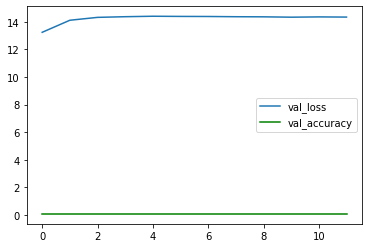

In [133]:
val_loss,val_accuracy=history.history['val_loss'],history.history['val_accuracy']
from matplotlib import pyplot as plt 
plt.plot(val_loss,label='val_loss')
plt.plot(val_accuracy,label='val_accuracy',c='g') 
plt.legend() 
plt.show() 

In [134]:
model.predict(x_test).shape 

(100, 10)

In [135]:
model.summary() 

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 8, 16)             0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 8, 32)             6272      
_________________________________________________________________
lstm_29 (LSTM)               (None, 8, 32)             8320      
_________________________________________________________________
lstm_30 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                330       
Total params: 23,242
Trainable params: 23,242
Non-trainable params: 0
_________________________________________________________________
